Извлечение признаков из сигналов...

Запуск GridSearchCV...
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Лучшие параметры: {'randomforestclassifier__max_depth': 15, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_split': 10, 'randomforestclassifier__n_estimators': 200, 'selectkbest__k': 20}

Отчет о классификации:
                     precision    recall  f1-score   support

        Нет сигнала       0.86      0.98      0.92      1428
Сигнал присутствует       0.98      0.85      0.91      1428

           accuracy                           0.91      2856
          macro avg       0.92      0.91      0.91      2856
       weighted avg       0.92      0.91      0.91      2856



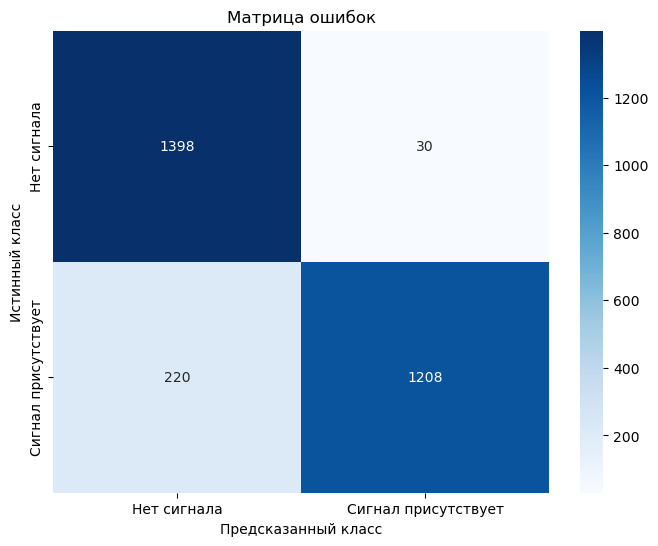

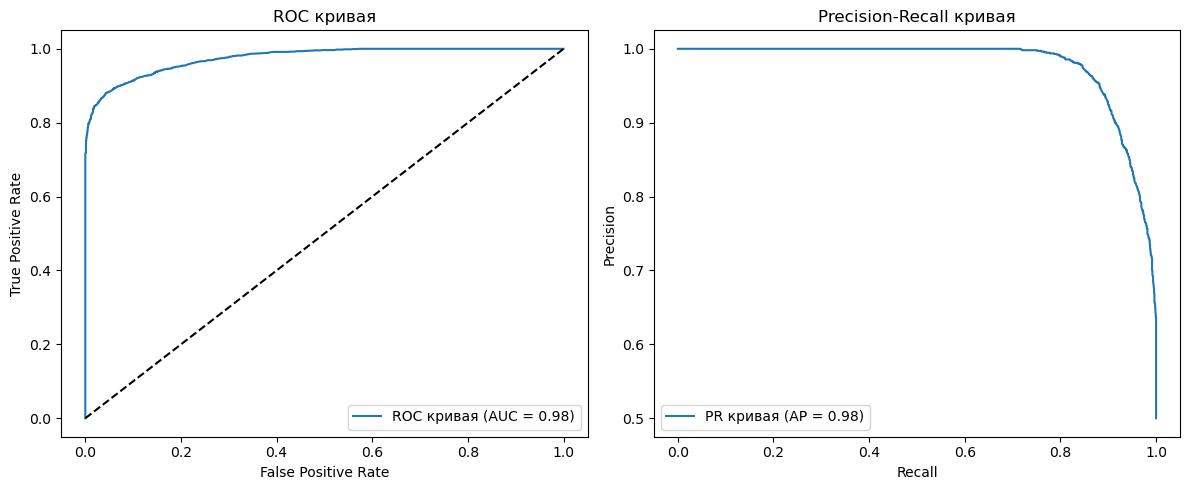

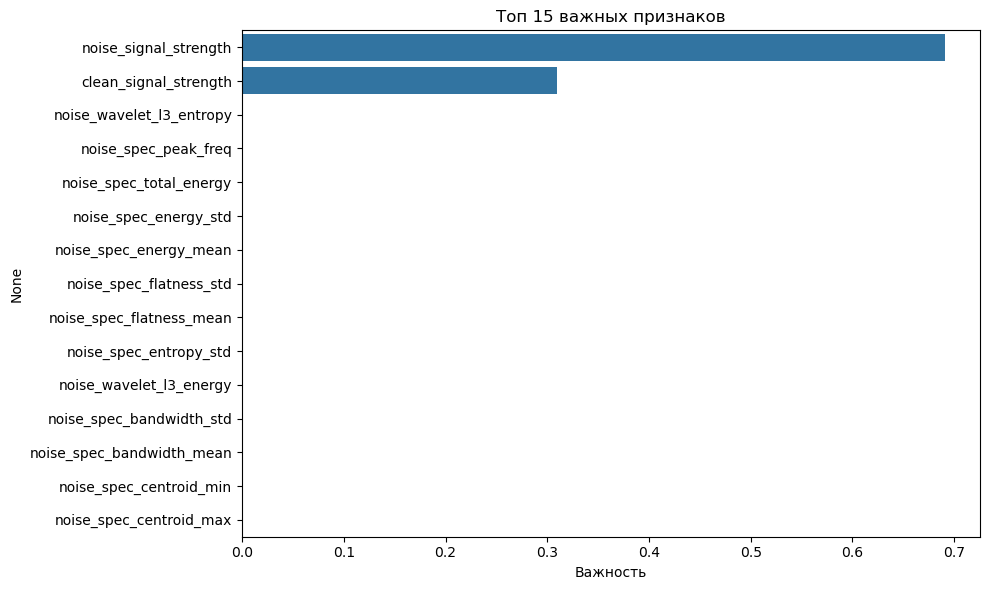

In [1]:
import numpy as np
import pandas as pd
import ast
import pywt
from scipy.signal import welch, spectrogram
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, roc_auc_score, 
                            confusion_matrix, roc_curve, precision_recall_curve,
                            average_precision_score)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_imb_pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# ----------------------------
# Data Loading and Preparation
# ----------------------------

# Load data
df = pd.read_csv('final_classification_dataset.csv')

def safe_convert(signal):
    """Безопасное преобразование сигнала в numpy array"""
    try:
        if isinstance(signal, str):
            arr = np.array(ast.literal_eval(signal))
        elif isinstance(signal, np.ndarray):
            arr = signal
        else:
            arr = np.zeros(100)
        
        # Стандартизация длины
        if len(arr) < 100:
            arr = np.pad(arr, (0, 100 - len(arr)), 'constant')
        return arr[:100]
    except:
        return np.zeros(100)

# Convert signal columns
df['clean_signal'] = df['clean_signal'].apply(safe_convert)
df['noise_signal'] = df['noise_signal'].apply(safe_convert)

# ----------------------------
# Feature Extraction Functions
# ----------------------------

def extract_enhanced_features(signal, fs=1000):
    """Извлечение временных, частотных и вейвлет-признаков"""
    features = {}
    
    # 1. Базовые статистические признаки
    features.update({
        'mean': np.mean(signal),
        'std': np.std(signal),
        'max': np.max(signal),
        'min': np.min(signal),
        'median': np.median(signal),
        'q25': np.percentile(signal, 25),
        'q75': np.percentile(signal, 75),
        'rms': np.sqrt(np.mean(signal**2)),
        'zero_crossings': ((signal[:-1] * signal[1:]) < 0).sum(),
        'entropy': np.sum(-signal * np.log(signal + 1e-10)),
        'skewness': pd.Series(signal).skew(),
        'kurtosis': pd.Series(signal).kurtosis()
    })
    
    # 2. Частотные признаки (метод Велча)
    try:
        f, Pxx = welch(signal, fs=fs, nperseg=min(len(signal), 256))
        features.update({
            'spectral_centroid': np.sum(f * Pxx) / np.sum(Pxx),
            'spectral_bandwidth': np.sqrt(np.sum((f - features['spectral_centroid'])**2 * Pxx)),
            'spectral_entropy': -np.sum(Pxx * np.log2(Pxx + 1e-12)),
            'spectral_flatness': np.exp(np.mean(np.log(Pxx + 1e-10))) / np.mean(Pxx),
            'spectral_energy': np.sum(Pxx),
            'peak_frequency': f[np.argmax(Pxx)]
        })
    except:
        features.update({k: 0 for k in ['spectral_centroid', 'spectral_bandwidth', 
                                      'spectral_entropy', 'spectral_flatness',
                                      'spectral_energy', 'peak_frequency']})
    
    # 3. Вейвлет-признаки
    try:
        coeffs = pywt.wavedec(signal, 'db1', level=3)
        for i, c in enumerate(coeffs):
            features.update({
                f'wavelet_l{i}_mean': np.mean(c),
                f'wavelet_l{i}_std': np.std(c),
                f'wavelet_l{i}_energy': np.sum(c**2),
                f'wavelet_l{i}_entropy': -np.sum(c**2 * np.log(c**2 + 1e-10))
            })
        total_energy = np.sum([np.sum(c**2) for c in coeffs])
        features.update({
            'wavelet_total_energy': total_energy,
            'wavelet_energy_ratio': np.sum(coeffs[0]**2) / (total_energy + 1e-10)
        })
    except:
        wavelet_features = {f'wavelet_l{i}_{j}': 0 for i in range(4) 
                          for j in ['mean', 'std', 'energy', 'entropy']}
        wavelet_features.update({
            'wavelet_total_energy': 0,
            'wavelet_energy_ratio': 0
        })
        features.update(wavelet_features)
    
    return features

def extract_spectrogram_features(signal, fs=1000):
    """Извлечение признаков из спектрограммы сигнала"""
    features = {}
    
    try:
        f, t, Sxx = spectrogram(signal, fs=fs, nperseg=256)

        # Спектральный центроид
        spectral_centroid = np.sum(f[:, None] * Sxx, axis=0) / np.sum(Sxx, axis=0)
        features.update({
            'spec_centroid_mean': np.mean(spectral_centroid),
            'spec_centroid_std': np.std(spectral_centroid),
            'spec_centroid_max': np.max(spectral_centroid),
            'spec_centroid_min': np.min(spectral_centroid)
        })

        # Спектральная ширина
        spectral_bandwidth = np.sqrt(np.sum((f[:, None] - spectral_centroid)**2 * Sxx, axis=0) / np.sum(Sxx, axis=0))
        features.update({
            'spec_bandwidth_mean': np.mean(spectral_bandwidth),
            'spec_bandwidth_std': np.std(spectral_bandwidth)
        })

        # Спектральная энтропия
        spectral_entropy = -np.sum(Sxx * np.log(Sxx + 1e-10), axis=0)
        features.update({
            'spec_entropy_mean': np.mean(spectral_entropy),
            'spec_entropy_std': np.std(spectral_entropy)
        })

        # Спектральная плоскость
        spectral_flatness = np.exp(np.mean(np.log(Sxx + 1e-10), axis=0)) / np.mean(Sxx, axis=0)
        features.update({
            'spec_flatness_mean': np.mean(spectral_flatness),
            'spec_flatness_std': np.std(spectral_flatness)
        })

        # Спектральная энергия
        spectral_energy = np.sum(Sxx, axis=0)
        features.update({
            'spec_energy_mean': np.mean(spectral_energy),
            'spec_energy_std': np.std(spectral_energy),
            'spec_total_energy': np.sum(Sxx),
            'spec_peak_freq': f[np.argmax(np.mean(Sxx, axis=1))]
        })
    except:
        spec_features = {
            'spec_centroid_mean': 0, 'spec_centroid_std': 0,
            'spec_centroid_max': 0, 'spec_centroid_min': 0,
            'spec_bandwidth_mean': 0, 'spec_bandwidth_std': 0,
            'spec_entropy_mean': 0, 'spec_entropy_std': 0,
            'spec_flatness_mean': 0, 'spec_flatness_std': 0,
            'spec_energy_mean': 0, 'spec_energy_std': 0,
            'spec_total_energy': 0, 'spec_peak_freq': 0
        }
        features.update(spec_features)
    
    return features

def extract_all_features(signal, fs=1000):
    """Извлечение всех признаков (временных, частотных, спектрограммных и вейвлет-признаков)"""
    # Ensure signal is numpy array
    if isinstance(signal, str):
        try:
            signal = np.array(ast.literal_eval(signal))
        except:
            signal = np.zeros(100)
    
    features = {}
    features.update(extract_enhanced_features(signal, fs))
    features.update(extract_spectrogram_features(signal, fs))
    return features

# ----------------------------
# Feature Extraction Execution
# ----------------------------

print("Извлечение признаков из сигналов...")
clean_features = pd.DataFrame(df['clean_signal'].apply(lambda x: extract_all_features(x, fs=1000)).tolist()).add_prefix('clean_')
noise_features = pd.DataFrame(df['noise_signal'].apply(lambda x: extract_all_features(x, fs=1000)).tolist()).add_prefix('noise_')

# Combine all features
X = pd.concat([clean_features, noise_features, 
               df[['clean_signal_strength', 'noise_signal_strength']]], axis=1)
y = df['class']

# Handle NaN/inf values
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

# ----------------------------
# Model Pipeline and Training
# ----------------------------

pipeline = make_imb_pipeline(
    RobustScaler(),
    SMOTE(random_state=42),
    SelectKBest(score_func=f_classif),
    RandomForestClassifier(random_state=42, class_weight='balanced')
)

param_grid = {
    'selectkbest__k': [15, 20, 25],
    'randomforestclassifier__n_estimators': [200, 250],
    'randomforestclassifier__max_depth': [15, 20, None],
    'randomforestclassifier__min_samples_split': [5, 10],
    'randomforestclassifier__max_features': ['sqrt', 'log2']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\nЗапуск GridSearchCV...")
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, 
                         scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search.fit(X, y)

best_model = grid_search.best_estimator_
print("\nЛучшие параметры:", grid_search.best_params_)

# ----------------------------
# Model Evaluation
# ----------------------------

y_pred = best_model.predict(X)
y_proba = best_model.predict_proba(X)[:, 1]

print("\nОтчет о классификации:")
print(classification_report(y, y_pred, target_names=['Нет сигнала', 'Сигнал присутствует']))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Нет сигнала', 'Сигнал присутствует'],
            yticklabels=['Нет сигнала', 'Сигнал присутствует'])
plt.title('Матрица ошибок')
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.show()

# ROC and PR Curves
fpr, tpr, _ = roc_curve(y, y_proba)
roc_auc = roc_auc_score(y, y_proba)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC кривая (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC кривая')
plt.legend(loc="lower right")

precision, recall, _ = precision_recall_curve(y, y_proba)
ap_score = average_precision_score(y, y_proba)

plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'PR кривая (AP = {ap_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall кривая')
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

# Feature Importance
selected_features = X.columns[best_model.named_steps['selectkbest'].get_support()]
importances = best_model.named_steps['randomforestclassifier'].feature_importances_
top_features = pd.Series(importances, index=selected_features).sort_values(ascending=False)[:15]

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title('Топ 15 важных признаков')
plt.xlabel('Важность')
plt.tight_layout()
plt.show()

Fitting 5 folds for each of 108 candidates, totalling 540 fits

Melhores parâmetros para MLP: {'mlpclassifier__activation': 'relu', 'mlpclassifier__alpha': 0.001, 'mlpclassifier__hidden_layer_sizes': (150,), 'mlpclassifier__learning_rate': 'constant', 'selectkbest__k': 25}

Relatório de Classificação para MLP:
                precision    recall  f1-score   support

     Não sinal       0.67      0.92      0.78      1428
Sinal presente       0.88      0.54      0.67      1428

      accuracy                           0.73      2856
     macro avg       0.77      0.73      0.72      2856
  weighted avg       0.77      0.73      0.72      2856



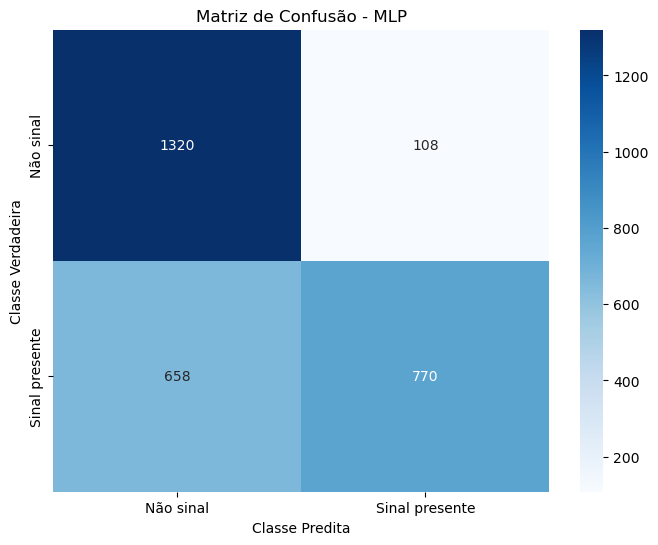

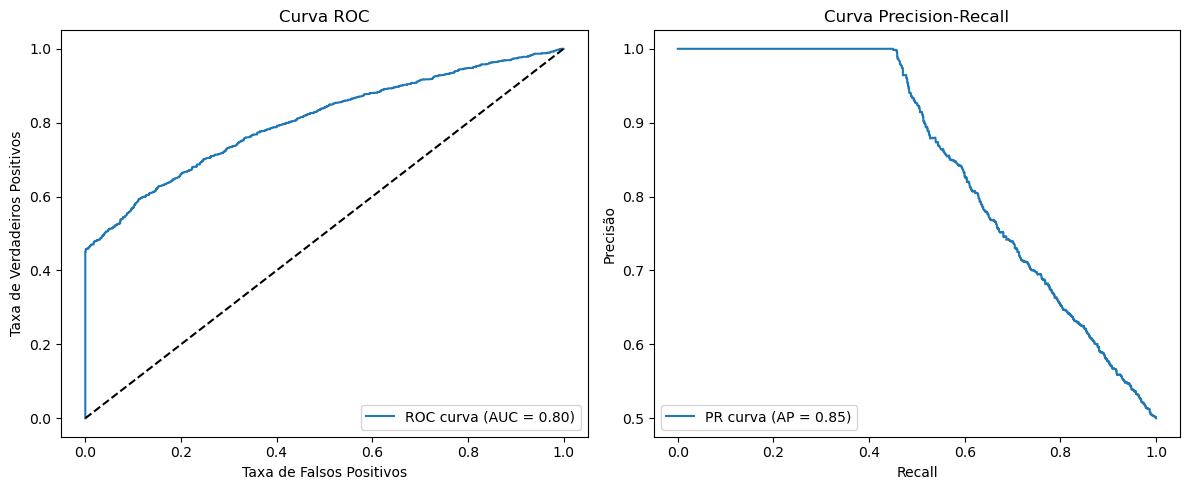

In [5]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

# ----------------------------
# Model Pipeline and Training for MLP
# ----------------------------

# Modificando o pipeline para usar MLPClassifier
pipeline_mlp = make_imb_pipeline(
    RobustScaler(),
    SMOTE(random_state=42),
    SelectKBest(score_func=f_classif),
    MLPClassifier(random_state=42, max_iter=1000, solver='adam')  # Remover o class_weight aqui
)

param_grid_mlp = {
    'selectkbest__k': [15, 20, 25],
    'mlpclassifier__hidden_layer_sizes': [(50,), (100,), (150,)],
    'mlpclassifier__activation': ['relu', 'tanh'],
    'mlpclassifier__alpha': [0.0001, 0.001, 0.01],
    'mlpclassifier__learning_rate': ['constant', 'adaptive'],
}

# GridSearchCV para otimizar os parâmetros da rede neural
grid_search_mlp = GridSearchCV(pipeline_mlp, param_grid_mlp, cv=cv, 
                               scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search_mlp.fit(X, y)

# Melhor modelo
best_mlp_model = grid_search_mlp.best_estimator_
print("\nMelhores parâmetros para MLP:", grid_search_mlp.best_params_)

# ----------------------------
# Model Evaluation for MLP
# ----------------------------

y_pred_mlp = best_mlp_model.predict(X)
y_proba_mlp = best_mlp_model.predict_proba(X)[:, 1]

print("\nRelatório de Classificação para MLP:")
print(classification_report(y, y_pred_mlp, target_names=['Não sinal', 'Sinal presente']))

# Confusion Matrix para MLP
plt.figure(figsize=(8, 6))
cm_mlp = confusion_matrix(y, y_pred_mlp)
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Não sinal', 'Sinal presente'],
            yticklabels=['Não sinal', 'Sinal presente'])
plt.title('Matriz de Confusão - MLP')
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Predita')
plt.show()

# ROC e PR Curvas para MLP
fpr_mlp, tpr_mlp, _ = roc_curve(y, y_proba_mlp)
roc_auc_mlp = roc_auc_score(y, y_proba_mlp)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr_mlp, tpr_mlp, label=f'ROC curva (AUC = {roc_auc_mlp:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")

precision_mlp, recall_mlp, _ = precision_recall_curve(y, y_proba_mlp)
ap_score_mlp = average_precision_score(y, y_proba_mlp)

plt.subplot(1, 2, 2)
plt.plot(recall_mlp, precision_mlp, label=f'PR curva (AP = {ap_score_mlp:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.title('Curva Precision-Recall')
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalização dos dados com StandardScaler (RobustScaler pode ser usado igualmente)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ---------------------------
# Construção da rede neural
# ---------------------------
print("Строим нейронную сеть...")

model = Sequential()

# Entrada e camada oculta
model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dropout(0.5))  # Dropout para evitar overfitting
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

# Camada de saída
model.add(Dense(1, activation='sigmoid'))  # Sigmoid para classificação binária

# Compilação do modelo
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Exibindo resumo do modelo
model.summary()


Строим нейронную сеть...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           6,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,705 (34.00 KB)

 Trainable params: 8,705 (34.00 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# ---------------------------
# Treinamento do modelo
# ---------------------------
print("Обучаем нейронную сеть...")

history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.3, verbose=2)


Обучаем нейронную сеть...
Epoch 1/50
44/44 - 2s - 35ms/step - accuracy: 0.5583 - loss: 0.6584 - val_accuracy: 0.6483 - val_loss: 0.6174
Epoch 2/50
44/44 - 0s - 3ms/step - accuracy: 0.6426 - loss: 0.5936 - val_accuracy: 0.6933 - val_loss: 0.5674
Epoch 3/50
44/44 - 0s - 4ms/step - accuracy: 0.6648 - loss: 0.5723 - val_accuracy: 0.7183 - val_loss: 0.5461
Epoch 4/50
44/44 - 0s - 3ms/step - accuracy: 0.6769 - loss: 0.5619 - val_accuracy: 0.7333 - val_loss: 0.5305
Epoch 5/50
44/44 - 0s - 3ms/step - accuracy: 0.6919 - loss: 0.5510 - val_accuracy: 0.7467 - val_loss: 0.5228
Epoch 6/50
44/44 - 0s - 3ms/step - accuracy: 0.7041 - loss: 0.5426 - val_accuracy: 0.7500 - val_loss: 0.5180
Epoch 7/50
44/44 - 0s - 3ms/step - accuracy: 0.7098 - loss: 0.5354 - val_accuracy: 0.7517 - val_loss: 0.5147
Epoch 8/50
44/44 - 0s - 3ms/step - accuracy: 0.7069 - loss: 0.5250 - val_accuracy: 0.7567 - val_loss: 0.5091
Epoch 9/50
44/44 - 0s - 3ms/step - accuracy: 0.7048 - loss: 0.5362 - val_accuracy: 0.7567 - val_loss:

Оценка модели...
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Отчет о классификации:
                     precision    recall  f1-score   support

          Не сигнал       0.60      0.95      0.74       396
Сигнал присутствует       0.92      0.46      0.61       461

           accuracy                           0.69       857
          macro avg       0.76      0.71      0.68       857
       weighted avg       0.77      0.69      0.67       857



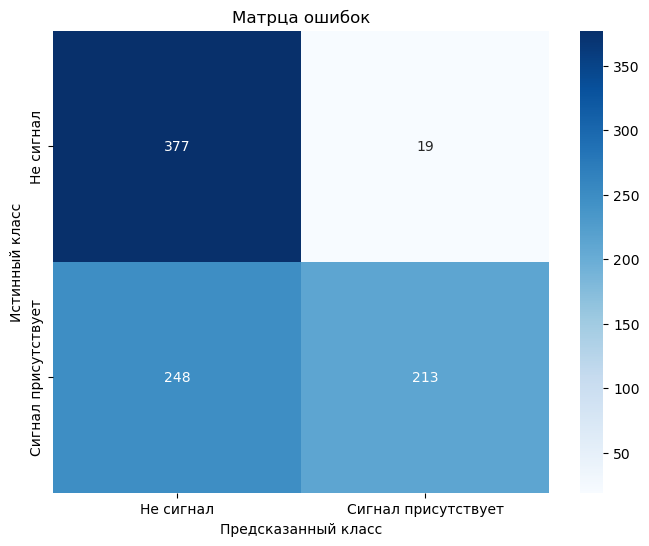

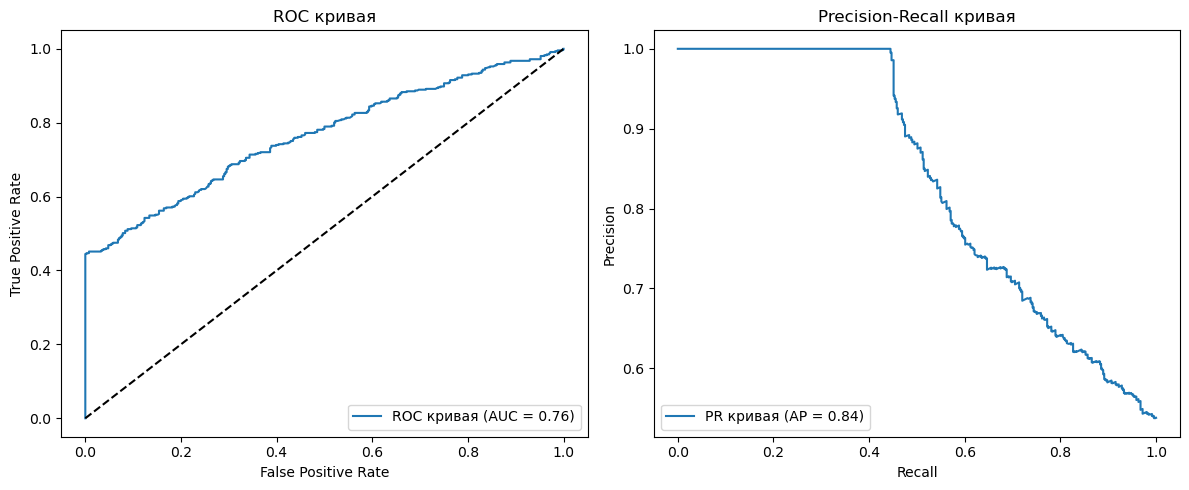

In [13]:
# ---------------------------
# Avaliação do modelo
# ---------------------------
print("Оценка модели...")

# Previsões na base de teste
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)  # Convertendo as probabilidades para classes

# Relatório de classificação
print("\nОтчет о классификации:")
print(classification_report(y_test, y_pred, target_names=['Не сигнал', 'Сигнал присутствует']))

# Matriz de confusão
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Не сигнал', 'Сигнал присутствует'],
            yticklabels=['Не сигнал', 'Сигнал присутствует'])
plt.title('Матрца ошибок')
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC кривая (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC кривая')
plt.legend(loc="lower right")

# Curva Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
ap_score = average_precision_score(y_test, y_pred_prob)

plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'PR кривая (AP = {ap_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall кривая')
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()


Строим нейронную сеть...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 128)                 │          13,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,553 (92.00 KB)

 Trainable params: 23,553 (92.00 KB)

 Non-trainable params: 0 (0.00 B)

Обучаем нейронную сеть...
Epoch 1/100
44/44 - 2s - 40ms/step - accuracy: 0.5347 - loss: 2.7341 - val_accuracy: 0.6383 - val_loss: 2.3568
Epoch 2/100
44/44 - 0s - 4ms/step - accuracy: 0.6240 - loss: 2.0825 - val_accuracy: 0.6500 - val_loss: 1.8074
Epoch 3/100
44/44 - 0s - 3ms/step - accuracy: 0.6519 - loss: 1.6201 - val_accuracy: 0.6617 - val_loss: 1.4170
Epoch 4/100
44/44 - 0s - 4ms/step - accuracy: 0.6705 - loss: 1.2942 - val_accuracy: 0.6833 - val_loss: 1.1480
Epoch 5/100
44/44 - 0s - 3ms/step - accuracy: 0.6905 - loss: 1.0659 - val_accuracy: 0.7017 - val_loss: 0.9629
Epoch 6/100
44/44 - 0s - 4ms/step - accuracy: 0.6912 - loss: 0.9190 - val_accuracy: 0.6933 - val_loss: 0.8388
Epoch 7/100
44/44 - 0s - 3ms/step - accuracy: 0.7105 - loss: 0.8114 - val_accuracy: 0.7067 - val_loss: 0.7555
Epoch 8/100
44/44 - 0s - 3ms/step - accuracy: 0.7062 - loss: 0.7406 - val_accuracy: 0.7050 - val_loss: 0.7004
Epoch 9/100
44/44 - 0s - 3ms/step - accuracy: 0.7105 - loss: 0.6976 - val_accuracy: 0.7083 - 

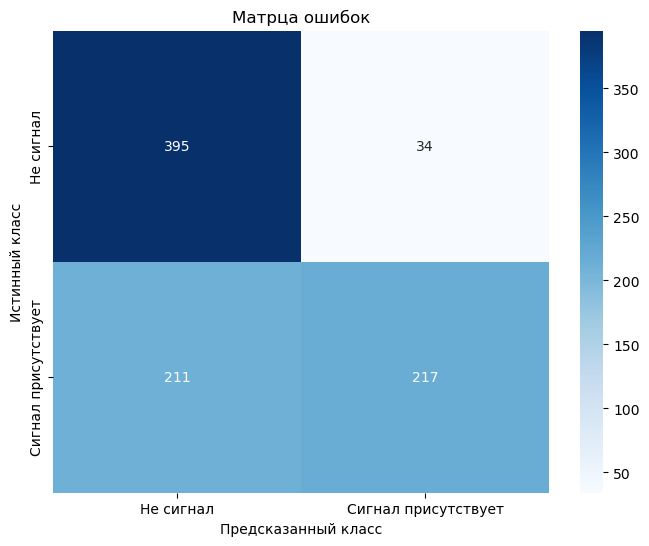

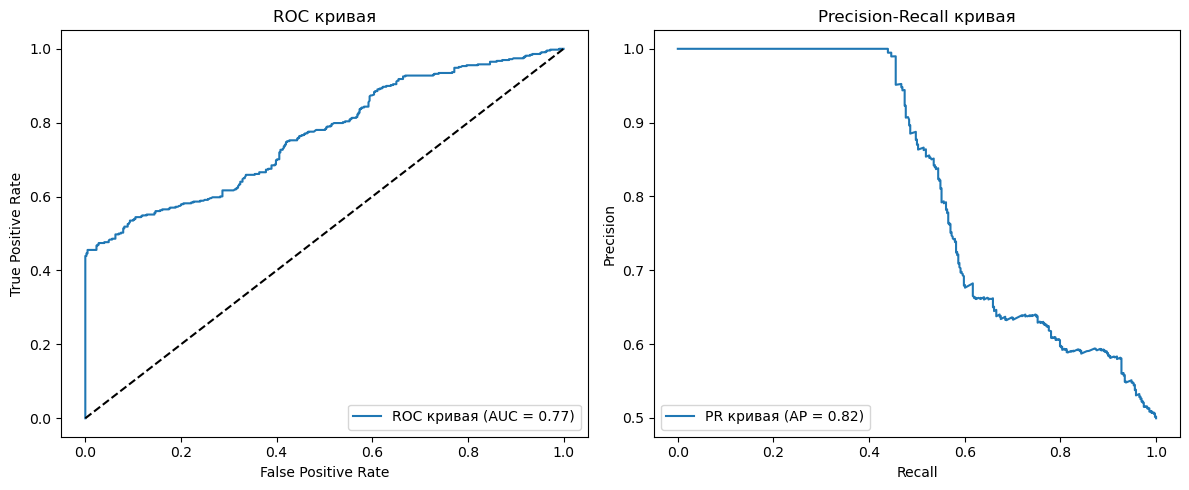

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler  # ou StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
import seaborn as sns
import matplotlib.pyplot as plt

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Escalonamento
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Construção da rede neural com arquitetura ajustada
print("Строим нейронную сеть...")

model = Sequential()
# Camada de entrada e primeira camada oculta
model.add(Dense(128, input_dim=X_train_scaled.shape[1], activation='relu', kernel_regularizer='l2'))
model.add(Dropout(0.4))
# Segunda camada oculta
model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
model.add(Dropout(0.4))
# Terceira camada oculta (opcional)
model.add(Dense(32, activation='relu', kernel_regularizer='l2'))
model.add(Dropout(0.3))
# Camada de saída
model.add(Dense(1, activation='sigmoid'))

# Compilação do modelo com taxa de aprendizado ajustada
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Callback para early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.summary()

# Treinamento do modelo
print("Обучаем нейронную сеть...")
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.3, callbacks=[early_stop], verbose=2)

# Avaliação do modelo
print("Оценка модели...")
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)

print("\nОтчет о классификации:")
print(classification_report(y_test, y_pred, target_names=['Не сигнал', 'Сигнал присутствует']))

# Matriz de confusão
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Не сигнал', 'Сигнал присутствует'], yticklabels=['Не сигнал', 'Сигнал присутствует'])
plt.title('Матрца ошибок')
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC кривая (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC кривая')
plt.legend(loc="lower right")

# Curva Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
ap_score = average_precision_score(y_test, y_pred_prob)
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'PR кривая (AP = {ap_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall кривая')
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()


Extraindo features dos sinais...
Construindo a rede neural MLP...


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                      │ (None, 64)                  │           6,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,705 (34.00 KB)

 Trainable params: 8,705 (34.00 KB)

 Non-trainable params: 0 (0.00 B)

Treinando a rede neural...
Epoch 1/50
44/44 - 1s - 28ms/step - accuracy: 0.5829 - loss: 0.6716 - val_accuracy: 0.6483 - val_loss: 0.6424
Epoch 2/50
44/44 - 0s - 3ms/step - accuracy: 0.6586 - loss: 0.6244 - val_accuracy: 0.6767 - val_loss: 0.5886
Epoch 3/50
44/44 - 0s - 3ms/step - accuracy: 0.6700 - loss: 0.5928 - val_accuracy: 0.6867 - val_loss: 0.5605
Epoch 4/50
44/44 - 0s - 3ms/step - accuracy: 0.6793 - loss: 0.5707 - val_accuracy: 0.7033 - val_loss: 0.5464
Epoch 5/50
44/44 - 0s - 3ms/step - accuracy: 0.7000 - loss: 0.5657 - val_accuracy: 0.7067 - val_loss: 0.5370
Epoch 6/50
44/44 - 0s - 3ms/step - accuracy: 0.7029 - loss: 0.5573 - val_accuracy: 0.7067 - val_loss: 0.5304
Epoch 7/50
44/44 - 0s - 3ms/step - accuracy: 0.7043 - loss: 0.5548 - val_accuracy: 0.7150 - val_loss: 0.5263
Epoch 8/50
44/44 - 0s - 3ms/step - accuracy: 0.7071 - loss: 0.5474 - val_accuracy: 0.7167 - val_loss: 0.5229
Epoch 9/50
44/44 - 0s - 3ms/step - accuracy: 0.7107 - loss: 0.5437 - val_accuracy: 0.7167 - val_loss

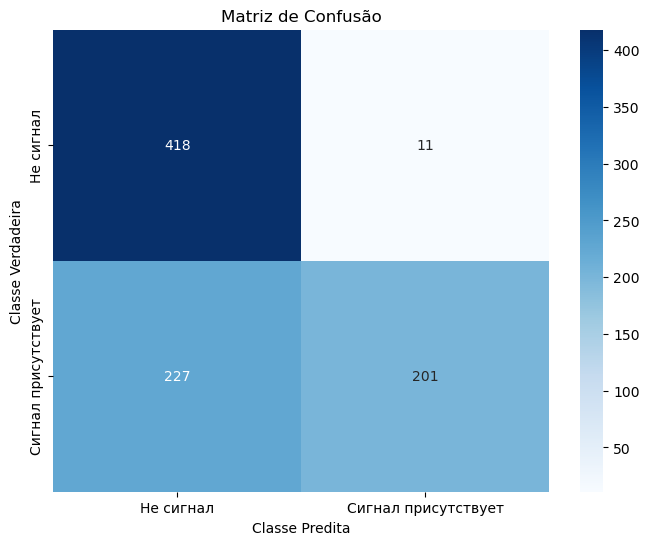

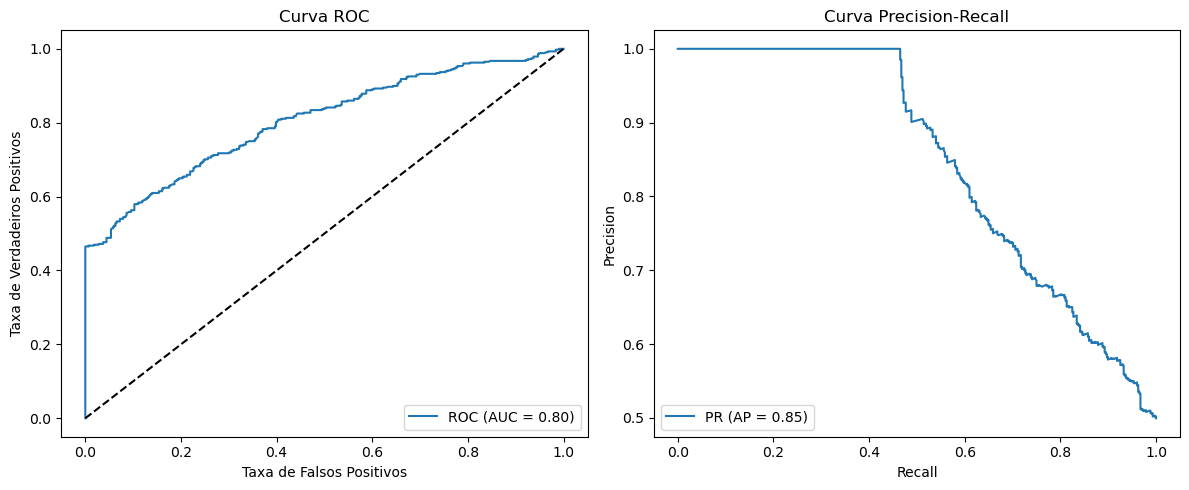

In [17]:
import numpy as np
import pandas as pd
import ast
import pywt
from scipy.signal import welch, spectrogram
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler  # Pode ser substituído por StandardScaler se preferir
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, precision_recall_curve, average_precision_score)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# ----------------------------
# Data Loading and Preparation
# ----------------------------

# Carrega o dataset
df = pd.read_csv('final_classification_dataset.csv')

def safe_convert(signal):
    """Conversão segura do sinal para numpy array com pad para 100 elementos"""
    try:
        if isinstance(signal, str):
            arr = np.array(ast.literal_eval(signal))
        elif isinstance(signal, np.ndarray):
            arr = signal
        else:
            arr = np.zeros(100)
        
        if len(arr) < 100:
            arr = np.pad(arr, (0, 100 - len(arr)), 'constant')
        return arr[:100]
    except:
        return np.zeros(100)

# Converte as colunas de sinal
df['clean_signal'] = df['clean_signal'].apply(safe_convert)
df['noise_signal'] = df['noise_signal'].apply(safe_convert)

# ----------------------------
# Feature Extraction Functions
# ----------------------------

def extract_enhanced_features(signal, fs=1000):
    features = {}
    features.update({
        'mean': np.mean(signal),
        'std': np.std(signal),
        'max': np.max(signal),
        'min': np.min(signal),
        'median': np.median(signal),
        'q25': np.percentile(signal, 25),
        'q75': np.percentile(signal, 75),
        'rms': np.sqrt(np.mean(signal**2)),
        'zero_crossings': ((signal[:-1] * signal[1:]) < 0).sum(),
        'entropy': np.sum(-signal * np.log(signal + 1e-10)),
        'skewness': pd.Series(signal).skew(),
        'kurtosis': pd.Series(signal).kurtosis()
    })
    try:
        f, Pxx = welch(signal, fs=fs, nperseg=min(len(signal), 256))
        features.update({
            'spectral_centroid': np.sum(f * Pxx) / np.sum(Pxx),
            'spectral_bandwidth': np.sqrt(np.sum((f - features['spectral_centroid'])**2 * Pxx)),
            'spectral_entropy': -np.sum(Pxx * np.log2(Pxx + 1e-12)),
            'spectral_flatness': np.exp(np.mean(np.log(Pxx + 1e-10))) / np.mean(Pxx),
            'spectral_energy': np.sum(Pxx),
            'peak_frequency': f[np.argmax(Pxx)]
        })
    except:
        features.update({k: 0 for k in ['spectral_centroid', 'spectral_bandwidth', 
                                          'spectral_entropy', 'spectral_flatness',
                                          'spectral_energy', 'peak_frequency']})
    try:
        coeffs = pywt.wavedec(signal, 'db1', level=3)
        for i, c in enumerate(coeffs):
            features.update({
                f'wavelet_l{i}_mean': np.mean(c),
                f'wavelet_l{i}_std': np.std(c),
                f'wavelet_l{i}_energy': np.sum(c**2),
                f'wavelet_l{i}_entropy': -np.sum(c**2 * np.log(c**2 + 1e-10))
            })
        total_energy = np.sum([np.sum(c**2) for c in coeffs])
        features.update({
            'wavelet_total_energy': total_energy,
            'wavelet_energy_ratio': np.sum(coeffs[0]**2) / (total_energy + 1e-10)
        })
    except:
        wavelet_features = {f'wavelet_l{i}_{j}': 0 for i in range(4) 
                            for j in ['mean', 'std', 'energy', 'entropy']}
        wavelet_features.update({
            'wavelet_total_energy': 0,
            'wavelet_energy_ratio': 0
        })
        features.update(wavelet_features)
    return features

def extract_spectrogram_features(signal, fs=1000):
    features = {}
    try:
        f, t, Sxx = spectrogram(signal, fs=fs, nperseg=256)
        spectral_centroid = np.sum(f[:, None] * Sxx, axis=0) / np.sum(Sxx, axis=0)
        features.update({
            'spec_centroid_mean': np.mean(spectral_centroid),
            'spec_centroid_std': np.std(spectral_centroid),
            'spec_centroid_max': np.max(spectral_centroid),
            'spec_centroid_min': np.min(spectral_centroid)
        })
        spectral_bandwidth = np.sqrt(np.sum((f[:, None] - spectral_centroid)**2 * Sxx, axis=0) / np.sum(Sxx, axis=0))
        features.update({
            'spec_bandwidth_mean': np.mean(spectral_bandwidth),
            'spec_bandwidth_std': np.std(spectral_bandwidth)
        })
        spectral_entropy = -np.sum(Sxx * np.log(Sxx + 1e-10), axis=0)
        features.update({
            'spec_entropy_mean': np.mean(spectral_entropy),
            'spec_entropy_std': np.std(spectral_entropy)
        })
        spectral_flatness = np.exp(np.mean(np.log(Sxx + 1e-10), axis=0)) / np.mean(Sxx, axis=0)
        features.update({
            'spec_flatness_mean': np.mean(spectral_flatness),
            'spec_flatness_std': np.std(spectral_flatness)
        })
        spectral_energy = np.sum(Sxx, axis=0)
        features.update({
            'spec_energy_mean': np.mean(spectral_energy),
            'spec_energy_std': np.std(spectral_energy),
            'spec_total_energy': np.sum(Sxx),
            'spec_peak_freq': f[np.argmax(np.mean(Sxx, axis=1))]
        })
    except:
        spec_features = {
            'spec_centroid_mean': 0, 'spec_centroid_std': 0,
            'spec_centroid_max': 0, 'spec_centroid_min': 0,
            'spec_bandwidth_mean': 0, 'spec_bandwidth_std': 0,
            'spec_entropy_mean': 0, 'spec_entropy_std': 0,
            'spec_flatness_mean': 0, 'spec_flatness_std': 0,
            'spec_energy_mean': 0, 'spec_energy_std': 0,
            'spec_total_energy': 0, 'spec_peak_freq': 0
        }
        features.update(spec_features)
    return features

def extract_all_features(signal, fs=1000):
    if isinstance(signal, str):
        try:
            signal = np.array(ast.literal_eval(signal))
        except:
            signal = np.zeros(100)
    features = {}
    features.update(extract_enhanced_features(signal, fs))
    features.update(extract_spectrogram_features(signal, fs))
    return features

# ----------------------------
# Extração dos Features
# ----------------------------

print("Extraindo features dos sinais...")
clean_features = pd.DataFrame(df['clean_signal'].apply(lambda x: extract_all_features(x, fs=1000)).tolist()).add_prefix('clean_')
noise_features = pd.DataFrame(df['noise_signal'].apply(lambda x: extract_all_features(x, fs=1000)).tolist()).add_prefix('noise_')

# Combina features e colunas de intensidade
X = pd.concat([clean_features, noise_features, df[['clean_signal_strength', 'noise_signal_strength']]], axis=1)
y = df['class']

X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

# ----------------------------
# Divisão em Treino e Teste
# ----------------------------

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# ----------------------------
# Balanceamento e Escalonamento
# ----------------------------

# Aplica SMOTE somente no conjunto de treino
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Escalonamento (RobustScaler ou StandardScaler)
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# ----------------------------
# Construção e Treinamento do Modelo MLP
# ----------------------------

print("Construindo a rede neural MLP...")
model = Sequential()
model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # Saída para classificação binária

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# EarlyStopping para evitar overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

print("Treinando a rede neural...")
history = model.fit(X_train_scaled, y_train_res, epochs=50, batch_size=32, validation_split=0.3,
                    callbacks=[early_stop], verbose=2)

# ----------------------------
# Avaliação do Modelo MLP
# ----------------------------

print("Avaliando o modelo MLP...")
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=['Не сигнал', 'Сигнал присутствует']))

# Matriz de Confusão
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Не сигнал', 'Сигнал присутствует'],
            yticklabels=['Не сигнал', 'Сигнал присутствует'])
plt.title('Matriz de Confusão')
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Predita')
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")

# Curva Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
ap_score = average_precision_score(y_test, y_pred_prob)
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'PR (AP = {ap_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()


Extraindo features dos sinais...
Construindo a rede neural MLP...


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 128)                 │          13,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,553 (92.00 KB)

 Trainable params: 23,553 (92.00 KB)

 Non-trainable params: 0 (0.00 B)

Treinando a rede neural...
Epoch 1/100
44/44 - 2s - 44ms/step - accuracy: 0.5993 - loss: 0.8944 - val_accuracy: 0.6850 - val_loss: 0.8425
Epoch 2/100
44/44 - 0s - 3ms/step - accuracy: 0.6629 - loss: 0.8100 - val_accuracy: 0.6867 - val_loss: 0.7472
Epoch 3/100
44/44 - 0s - 3ms/step - accuracy: 0.6814 - loss: 0.7278 - val_accuracy: 0.6850 - val_loss: 0.6782
Epoch 4/100
44/44 - 0s - 3ms/step - accuracy: 0.7050 - loss: 0.6734 - val_accuracy: 0.7067 - val_loss: 0.6402
Epoch 5/100
44/44 - 0s - 3ms/step - accuracy: 0.7036 - loss: 0.6455 - val_accuracy: 0.7100 - val_loss: 0.6181
Epoch 6/100
44/44 - 0s - 3ms/step - accuracy: 0.7121 - loss: 0.6271 - val_accuracy: 0.7133 - val_loss: 0.6019
Epoch 7/100
44/44 - 0s - 3ms/step - accuracy: 0.7114 - loss: 0.6136 - val_accuracy: 0.7133 - val_loss: 0.5910
Epoch 8/100
44/44 - 0s - 4ms/step - accuracy: 0.7136 - loss: 0.6055 - val_accuracy: 0.7100 - val_loss: 0.5829
Epoch 9/100
44/44 - 0s - 3ms/step - accuracy: 0.7179 - loss: 0.5917 - val_accuracy: 0.7083 -

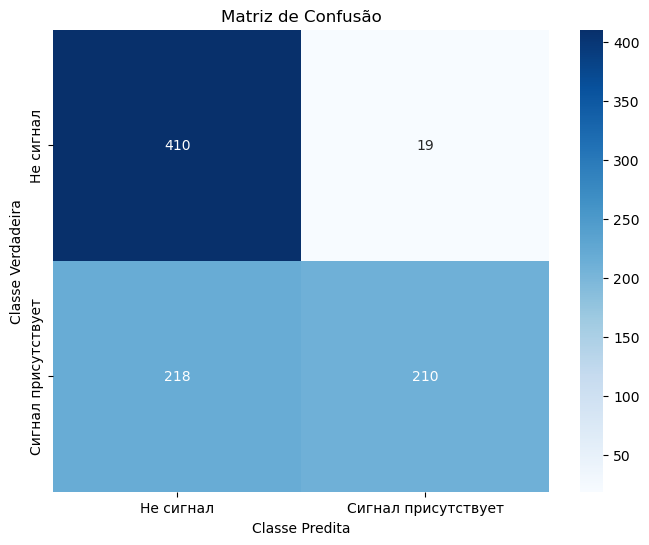

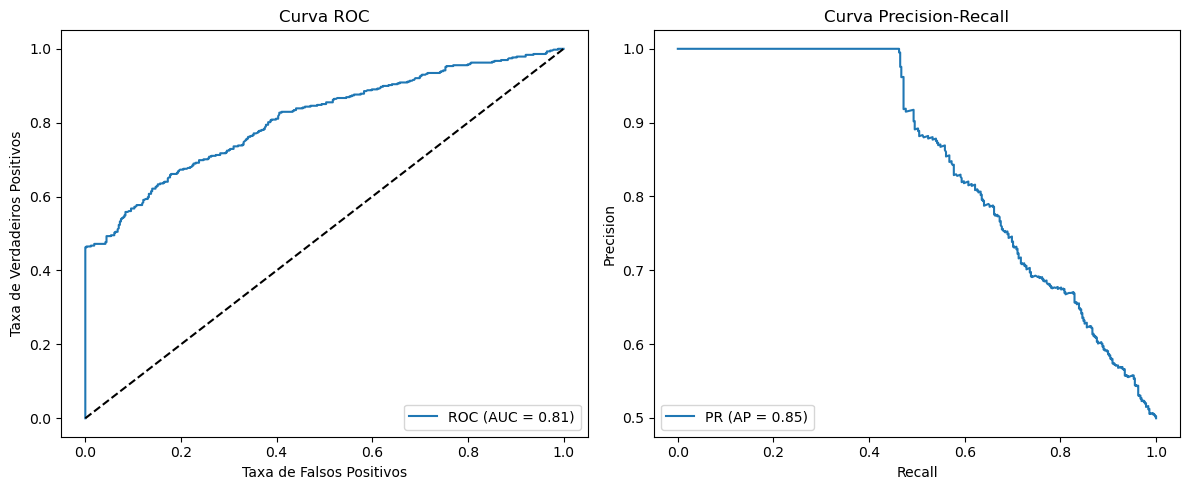

In [19]:
import numpy as np
import pandas as pd
import ast
import pywt
from scipy.signal import welch, spectrogram
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, precision_recall_curve,
                             average_precision_score)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# ----------------------------
# Data Loading and Preparation
# ----------------------------

# Carrega o dataset
df = pd.read_csv('final_classification_dataset.csv')

def safe_convert(signal):
    """Conversão segura do sinal para numpy array com pad para 100 elementos"""
    try:
        if isinstance(signal, str):
            arr = np.array(ast.literal_eval(signal))
        elif isinstance(signal, np.ndarray):
            arr = signal
        else:
            arr = np.zeros(100)
        # Pad para ter sempre 100 elementos
        if len(arr) < 100:
            arr = np.pad(arr, (0, 100 - len(arr)), 'constant')
        return arr[:100]
    except:
        return np.zeros(100)

# Converte as colunas de sinal
df['clean_signal'] = df['clean_signal'].apply(safe_convert)
df['noise_signal'] = df['noise_signal'].apply(safe_convert)

# ----------------------------
# Feature Extraction Functions
# ----------------------------

def extract_enhanced_features(signal, fs=1000):
    features = {}
    features.update({
        'mean': np.mean(signal),
        'std': np.std(signal),
        'max': np.max(signal),
        'min': np.min(signal),
        'median': np.median(signal),
        'q25': np.percentile(signal, 25),
        'q75': np.percentile(signal, 75),
        'rms': np.sqrt(np.mean(signal**2)),
        'zero_crossings': ((signal[:-1] * signal[1:]) < 0).sum(),
        'entropy': np.sum(-signal * np.log(signal + 1e-10)),
        'skewness': pd.Series(signal).skew(),
        'kurtosis': pd.Series(signal).kurtosis()
    })
    try:
        f, Pxx = welch(signal, fs=fs, nperseg=min(len(signal), 256))
        features.update({
            'spectral_centroid': np.sum(f * Pxx) / np.sum(Pxx),
            'spectral_bandwidth': np.sqrt(np.sum((f - features['spectral_centroid'])**2 * Pxx)),
            'spectral_entropy': -np.sum(Pxx * np.log2(Pxx + 1e-12)),
            'spectral_flatness': np.exp(np.mean(np.log(Pxx + 1e-10))) / np.mean(Pxx),
            'spectral_energy': np.sum(Pxx),
            'peak_frequency': f[np.argmax(Pxx)]
        })
    except:
        features.update({k: 0 for k in ['spectral_centroid', 'spectral_bandwidth', 
                                          'spectral_entropy', 'spectral_flatness',
                                          'spectral_energy', 'peak_frequency']})
    try:
        coeffs = pywt.wavedec(signal, 'db1', level=3)
        for i, c in enumerate(coeffs):
            features.update({
                f'wavelet_l{i}_mean': np.mean(c),
                f'wavelet_l{i}_std': np.std(c),
                f'wavelet_l{i}_energy': np.sum(c**2),
                f'wavelet_l{i}_entropy': -np.sum(c**2 * np.log(c**2 + 1e-10))
            })
        total_energy = np.sum([np.sum(c**2) for c in coeffs])
        features.update({
            'wavelet_total_energy': total_energy,
            'wavelet_energy_ratio': np.sum(coeffs[0]**2) / (total_energy + 1e-10)
        })
    except:
        wavelet_features = {f'wavelet_l{i}_{j}': 0 for i in range(4) 
                            for j in ['mean', 'std', 'energy', 'entropy']}
        wavelet_features.update({
            'wavelet_total_energy': 0,
            'wavelet_energy_ratio': 0
        })
        features.update(wavelet_features)
    return features

def extract_spectrogram_features(signal, fs=1000):
    features = {}
    try:
        f, t, Sxx = spectrogram(signal, fs=fs, nperseg=256)
        spectral_centroid = np.sum(f[:, None] * Sxx, axis=0) / np.sum(Sxx, axis=0)
        features.update({
            'spec_centroid_mean': np.mean(spectral_centroid),
            'spec_centroid_std': np.std(spectral_centroid),
            'spec_centroid_max': np.max(spectral_centroid),
            'spec_centroid_min': np.min(spectral_centroid)
        })
        spectral_bandwidth = np.sqrt(np.sum((f[:, None] - spectral_centroid)**2 * Sxx, axis=0) / np.sum(Sxx, axis=0))
        features.update({
            'spec_bandwidth_mean': np.mean(spectral_bandwidth),
            'spec_bandwidth_std': np.std(spectral_bandwidth)
        })
        spectral_entropy = -np.sum(Sxx * np.log(Sxx + 1e-10), axis=0)
        features.update({
            'spec_entropy_mean': np.mean(spectral_entropy),
            'spec_entropy_std': np.std(spectral_entropy)
        })
        spectral_flatness = np.exp(np.mean(np.log(Sxx + 1e-10), axis=0)) / np.mean(Sxx, axis=0)
        features.update({
            'spec_flatness_mean': np.mean(spectral_flatness),
            'spec_flatness_std': np.std(spectral_flatness)
        })
        spectral_energy = np.sum(Sxx, axis=0)
        features.update({
            'spec_energy_mean': np.mean(spectral_energy),
            'spec_energy_std': np.std(spectral_energy),
            'spec_total_energy': np.sum(Sxx),
            'spec_peak_freq': f[np.argmax(np.mean(Sxx, axis=1))]
        })
    except:
        spec_features = {
            'spec_centroid_mean': 0, 'spec_centroid_std': 0,
            'spec_centroid_max': 0, 'spec_centroid_min': 0,
            'spec_bandwidth_mean': 0, 'spec_bandwidth_std': 0,
            'spec_entropy_mean': 0, 'spec_entropy_std': 0,
            'spec_flatness_mean': 0, 'spec_flatness_std': 0,
            'spec_energy_mean': 0, 'spec_energy_std': 0,
            'spec_total_energy': 0, 'spec_peak_freq': 0
        }
        features.update(spec_features)
    return features

def extract_all_features(signal, fs=1000):
    if isinstance(signal, str):
        try:
            signal = np.array(ast.literal_eval(signal))
        except:
            signal = np.zeros(100)
    features = {}
    features.update(extract_enhanced_features(signal, fs))
    features.update(extract_spectrogram_features(signal, fs))
    return features

# ----------------------------
# Extração dos Features
# ----------------------------

print("Extraindo features dos sinais...")
clean_features = pd.DataFrame(df['clean_signal'].apply(lambda x: extract_all_features(x, fs=1000)).tolist()).add_prefix('clean_')
noise_features = pd.DataFrame(df['noise_signal'].apply(lambda x: extract_all_features(x, fs=1000)).tolist()).add_prefix('noise_')

# Combina features com colunas de intensidade
X = pd.concat([clean_features, noise_features, df[['clean_signal_strength', 'noise_signal_strength']]], axis=1)
y = df['class']

X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

# ----------------------------
# Divisão em Treino e Teste
# ----------------------------

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# ----------------------------
# Balanceamento e Escalonamento
# ----------------------------

# Aplica SMOTE somente no conjunto de treino
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Escalonamento dos dados
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# ----------------------------
# Construção e Treinamento do Modelo MLP
# ----------------------------

print("Construindo a rede neural MLP...")

model = Sequential()
model.add(Dense(128, input_dim=X_train_scaled.shape[1], activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

print("Treinando a rede neural...")
history = model.fit(X_train_scaled, y_train_res, epochs=100, batch_size=32, validation_split=0.3,
                    callbacks=[early_stop], verbose=2)

# ----------------------------
# Avaliação do Modelo MLP
# ----------------------------

print("Avaliando o modelo MLP...")
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=['Не сигнал', 'Сигнал присутствует']))

# Matriz de Confusão
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Не сигнал', 'Сигнал присутствует'],
            yticklabels=['Не сигнал', 'Сигнал присутствует'])
plt.title('Matriz de Confusão')
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Predita')
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")

# Curva Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
ap_score = average_precision_score(y_test, y_pred_prob)
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'PR (AP = {ap_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()


Extraindo features dos sinais...
Construindo a rede neural MLP...


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                     │ (None, 128)                 │          13,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,553 (92.00 KB)

 Trainable params: 23,553 (92.00 KB)

 Non-trainable params: 0 (0.00 B)

Treinando a rede neural...
Epoch 1/100
44/44 - 2s - 39ms/step - accuracy: 0.4850 - loss: 1.0536 - val_accuracy: 0.5133 - val_loss: 0.8434
Epoch 2/100
44/44 - 0s - 4ms/step - accuracy: 0.5329 - loss: 0.9413 - val_accuracy: 0.6233 - val_loss: 0.7603
Epoch 3/100
44/44 - 0s - 3ms/step - accuracy: 0.6100 - loss: 0.8654 - val_accuracy: 0.6433 - val_loss: 0.7064
Epoch 4/100
44/44 - 0s - 4ms/step - accuracy: 0.6429 - loss: 0.8166 - val_accuracy: 0.6667 - val_loss: 0.6664
Epoch 5/100
44/44 - 0s - 3ms/step - accuracy: 0.6643 - loss: 0.7828 - val_accuracy: 0.6850 - val_loss: 0.6352
Epoch 6/100
44/44 - 0s - 3ms/step - accuracy: 0.6829 - loss: 0.7636 - val_accuracy: 0.7033 - val_loss: 0.6190
Epoch 7/100
44/44 - 0s - 3ms/step - accuracy: 0.6936 - loss: 0.7464 - val_accuracy: 0.7050 - val_loss: 0.6070
Epoch 8/100
44/44 - 0s - 3ms/step - accuracy: 0.6943 - loss: 0.7425 - val_accuracy: 0.7067 - val_loss: 0.6023
Epoch 9/100
44/44 - 0s - 4ms/step - accuracy: 0.7014 - loss: 0.7235 - val_accuracy: 0.7050 -

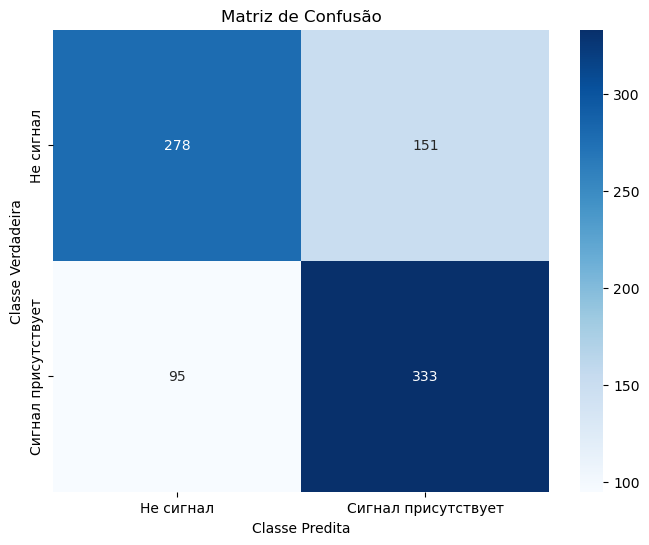

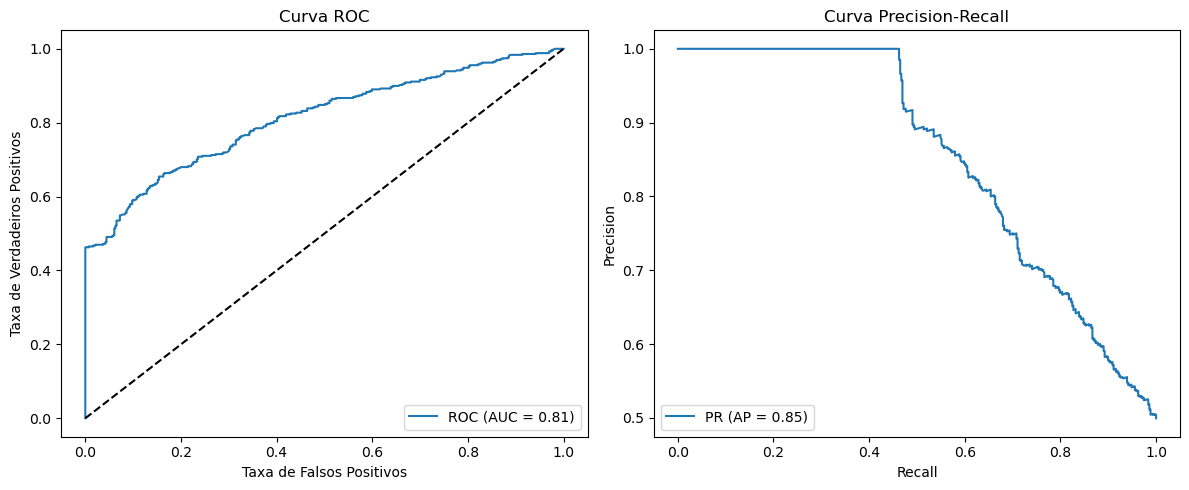

In [21]:
import numpy as np
import pandas as pd
import ast
import pywt
from scipy.signal import welch, spectrogram
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, precision_recall_curve,
                             average_precision_score)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# ----------------------------
# Data Loading and Preparation
# ----------------------------
df = pd.read_csv('final_classification_dataset.csv')

def safe_convert(signal):
    try:
        if isinstance(signal, str):
            arr = np.array(ast.literal_eval(signal))
        elif isinstance(signal, np.ndarray):
            arr = signal
        else:
            arr = np.zeros(100)
        if len(arr) < 100:
            arr = np.pad(arr, (0, 100 - len(arr)), 'constant')
        return arr[:100]
    except:
        return np.zeros(100)

df['clean_signal'] = df['clean_signal'].apply(safe_convert)
df['noise_signal'] = df['noise_signal'].apply(safe_convert)

# ----------------------------
# Feature Extraction Functions
# ----------------------------
def extract_enhanced_features(signal, fs=1000):
    features = {
        'mean': np.mean(signal),
        'std': np.std(signal),
        'max': np.max(signal),
        'min': np.min(signal),
        'median': np.median(signal),
        'q25': np.percentile(signal, 25),
        'q75': np.percentile(signal, 75),
        'rms': np.sqrt(np.mean(signal**2)),
        'zero_crossings': ((signal[:-1] * signal[1:]) < 0).sum(),
        'entropy': np.sum(-signal * np.log(signal + 1e-10)),
        'skewness': pd.Series(signal).skew(),
        'kurtosis': pd.Series(signal).kurtosis()
    }
    try:
        f, Pxx = welch(signal, fs=fs, nperseg=min(len(signal), 256))
        features.update({
            'spectral_centroid': np.sum(f * Pxx) / np.sum(Pxx),
            'spectral_bandwidth': np.sqrt(np.sum((f - features['spectral_centroid'])**2 * Pxx)),
            'spectral_entropy': -np.sum(Pxx * np.log2(Pxx + 1e-12)),
            'spectral_flatness': np.exp(np.mean(np.log(Pxx + 1e-10))) / np.mean(Pxx),
            'spectral_energy': np.sum(Pxx),
            'peak_frequency': f[np.argmax(Pxx)]
        })
    except:
        features.update({k: 0 for k in ['spectral_centroid', 'spectral_bandwidth', 
                                          'spectral_entropy', 'spectral_flatness',
                                          'spectral_energy', 'peak_frequency']})
    try:
        coeffs = pywt.wavedec(signal, 'db1', level=3)
        for i, c in enumerate(coeffs):
            features.update({
                f'wavelet_l{i}_mean': np.mean(c),
                f'wavelet_l{i}_std': np.std(c),
                f'wavelet_l{i}_energy': np.sum(c**2),
                f'wavelet_l{i}_entropy': -np.sum(c**2 * np.log(c**2 + 1e-10))
            })
        total_energy = np.sum([np.sum(c**2) for c in coeffs])
        features.update({
            'wavelet_total_energy': total_energy,
            'wavelet_energy_ratio': np.sum(coeffs[0]**2) / (total_energy + 1e-10)
        })
    except:
        wavelet_features = {f'wavelet_l{i}_{j}': 0 for i in range(4) for j in ['mean', 'std', 'energy', 'entropy']}
        wavelet_features.update({'wavelet_total_energy': 0, 'wavelet_energy_ratio': 0})
        features.update(wavelet_features)
    return features

def extract_spectrogram_features(signal, fs=1000):
    features = {}
    try:
        f, t, Sxx = spectrogram(signal, fs=fs, nperseg=256)
        spectral_centroid = np.sum(f[:, None] * Sxx, axis=0) / np.sum(Sxx, axis=0)
        features.update({
            'spec_centroid_mean': np.mean(spectral_centroid),
            'spec_centroid_std': np.std(spectral_centroid),
            'spec_centroid_max': np.max(spectral_centroid),
            'spec_centroid_min': np.min(spectral_centroid)
        })
        spectral_bandwidth = np.sqrt(np.sum((f[:, None] - spectral_centroid)**2 * Sxx, axis=0) / np.sum(Sxx, axis=0))
        features.update({
            'spec_bandwidth_mean': np.mean(spectral_bandwidth),
            'spec_bandwidth_std': np.std(spectral_bandwidth)
        })
        spectral_entropy = -np.sum(Sxx * np.log(Sxx + 1e-10), axis=0)
        features.update({
            'spec_entropy_mean': np.mean(spectral_entropy),
            'spec_entropy_std': np.std(spectral_entropy)
        })
        spectral_flatness = np.exp(np.mean(np.log(Sxx + 1e-10), axis=0)) / np.mean(Sxx, axis=0)
        features.update({
            'spec_flatness_mean': np.mean(spectral_flatness),
            'spec_flatness_std': np.std(spectral_flatness)
        })
        spectral_energy = np.sum(Sxx, axis=0)
        features.update({
            'spec_energy_mean': np.mean(spectral_energy),
            'spec_energy_std': np.std(spectral_energy),
            'spec_total_energy': np.sum(Sxx),
            'spec_peak_freq': f[np.argmax(np.mean(Sxx, axis=1))]
        })
    except:
        spec_features = {
            'spec_centroid_mean': 0, 'spec_centroid_std': 0,
            'spec_centroid_max': 0, 'spec_centroid_min': 0,
            'spec_bandwidth_mean': 0, 'spec_bandwidth_std': 0,
            'spec_entropy_mean': 0, 'spec_entropy_std': 0,
            'spec_flatness_mean': 0, 'spec_flatness_std': 0,
            'spec_energy_mean': 0, 'spec_energy_std': 0,
            'spec_total_energy': 0, 'spec_peak_freq': 0
        }
        features.update(spec_features)
    return features

def extract_all_features(signal, fs=1000):
    if isinstance(signal, str):
        try:
            signal = np.array(ast.literal_eval(signal))
        except:
            signal = np.zeros(100)
    features = {}
    features.update(extract_enhanced_features(signal, fs))
    features.update(extract_spectrogram_features(signal, fs))
    return features

# ----------------------------
# Extração dos Features
# ----------------------------
print("Extraindo features dos sinais...")
clean_features = pd.DataFrame(df['clean_signal'].apply(lambda x: extract_all_features(x, fs=1000)).tolist()).add_prefix('clean_')
noise_features = pd.DataFrame(df['noise_signal'].apply(lambda x: extract_all_features(x, fs=1000)).tolist()).add_prefix('noise_')
X = pd.concat([clean_features, noise_features, df[['clean_signal_strength', 'noise_signal_strength']]], axis=1)
y = df['class']
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

# ----------------------------
# Divisão em Treino e Teste
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# ----------------------------
# Balanceamento e Escalonamento
# ----------------------------
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# ----------------------------
# Construção e Treinamento do Modelo MLP
# ----------------------------
print("Construindo a rede neural MLP...")

model = Sequential()
model.add(Dense(128, input_dim=X_train_scaled.shape[1], activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Exemplo: ajuste de class_weight (opcional, se desejar penalizar mais a classe positiva)
# Como os dados já foram balanceados pelo SMOTE, esse parâmetro pode ser testado para melhorar a sensibilidade.
class_weight = {0: 1.0, 1: 1.5}

print("Treinando a rede neural...")
history = model.fit(X_train_scaled, y_train_res, epochs=100, batch_size=32, validation_split=0.3,
                    callbacks=[early_stop], verbose=2, class_weight=class_weight)

# ----------------------------
# Avaliação do Modelo MLP
# ----------------------------
print("Avaliando o modelo MLP...")
y_pred_prob = model.predict(X_test_scaled)
# Ajuste do threshold: experimente valores abaixo de 0.5 para melhorar o recall da classe positiva
threshold = 0.45
y_pred = (y_pred_prob > threshold).astype(int)

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=['Не сигнал', 'Сигнал присутствует']))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Не сигнал', 'Сигнал присутствует'],
            yticklabels=['Не сигнал', 'Сигнал присутствует'])
plt.title('Matriz de Confusão')
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Predita')
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")

precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
ap_score = average_precision_score(y_test, y_pred_prob)
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'PR (AP = {ap_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()


In [27]:
# Pipeline corrigido para SVM
svm_pipeline = make_imb_pipeline(
    RobustScaler(),
    SMOTE(random_state=42),
    SelectKBest(score_func=f_classif),
    CalibratedClassifierCV(SVC(random_state=42, probability=False), cv=3)
)

# Grade de parâmetros corrigida
svm_param_grid = {
    'selectkbest__k': [15, 20, 25],
    'calibratedclassifiercv__estimator__C': [0.1, 1, 10],  # Corrigido para estimator__
    'calibratedclassifiercv__estimator__gamma': ['scale', 'auto', 0.01, 0.1],  # Corrigido
    'calibratedclassifiercv__estimator__kernel': ['rbf'],  # Corrigido
    'calibratedclassifiercv__method': ['sigmoid', 'isotonic']
}

print("\nЗапуск GridSearchCV для SVM (исправленная версия)...")
svm_grid_search = GridSearchCV(svm_pipeline, svm_param_grid, cv=cv, 
                             scoring='roc_auc', n_jobs=-1, verbose=2)
svm_grid_search.fit(X, y)

svm_best_model = svm_grid_search.best_estimator_
print("\nЛучшие параметры SVM:", svm_grid_search.best_params_)


Запуск GridSearchCV для SVM (исправленная версия)...
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Лучшие параметры SVM: {'calibratedclassifiercv__estimator__C': 10, 'calibratedclassifiercv__estimator__gamma': 'scale', 'calibratedclassifiercv__estimator__kernel': 'rbf', 'calibratedclassifiercv__method': 'isotonic', 'selectkbest__k': 25}
